In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import random
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
from pprint import pprint

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# fix random number generation aka regenerate the same random numbers every time (such as weight and bias initialization )
def set_random_seed(seed=7, deterministic=True):
    """Set random seed, for python, numpy, pytorch

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: True.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False 
seed=7        
set_random_seed(seed=seed)

In [16]:
df = pd.read_csv("../data/data.csv")
df.head(7)

,weekday_name,month,leap_year_condition,decade,output,output_year_digit,output_year,valid_years_list,valid_day_list,decade4,decade100,decade400,valid_group_days_index
0,2,1,0,180,1-1-1800,0,1800,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
1,3,1,0,180,1-1-1801,1,1801,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
2,4,1,0,180,1-1-1802,2,1802,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
3,5,1,0,180,1-1-1803,3,1803,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
4,6,1,1,180,1-1-1804,4,1804,"[4, 8, 4, 4, 4, 4, 4, 4]","[1, 8, 15, 22, 29]",0,0,1,7
5,1,1,0,180,1-1-1805,5,1805,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
6,2,1,0,180,1-1-1806,6,1806,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7


- given the columns features we can't by any means diffrentiate between the day 1 or day 8 or 15 or 22 or 28 because they may share the same exact feature columns values and they all still correct, and the model see them all as the same thing, so i make lists for the identical days from the feature columns point of view, and instead of training the model to select certain day, i trained the model to select index of days-list which i named "groups", as example if the output of the model is 0 then it equivalent to selecting any day from these days [1, 8, 15, 22], if the output is 1 so it's equivalent to selecting any number from [2, 9, 16, 23] and so on(see groups_dict dictionary)

In [17]:
# list of all possibole (10) output lists, the output must be one of theses lists
groups = [[1, 8, 15, 22], 
         [2, 9, 16, 23], 
         [3, 10, 17, 24], 
         [4, 11, 18, 25], 
         [5, 12, 19, 26], 
         [6, 13, 20, 27], 
         [7, 14, 21, 28],
         [1, 8, 15, 22, 29], 
         [2, 9, 16, 23, 30], 
         [3, 10, 17, 24, 31]]
groups_dict = dict(enumerate(groups))
groups_dict

{0: [1, 8, 15, 22],
 1: [2, 9, 16, 23],
 2: [3, 10, 17, 24],
 3: [4, 11, 18, 25],
 4: [5, 12, 19, 26],
 5: [6, 13, 20, 27],
 6: [7, 14, 21, 28],
 7: [1, 8, 15, 22, 29],
 8: [2, 9, 16, 23, 30],
 9: [3, 10, 17, 24, 31]}

**B- training for getting the day**

In [18]:
df[["weekday_name", "month", "output_year", "leap_year_condition", "valid_group_days_index"]].head()

,weekday_name,month,output_year,leap_year_condition,valid_group_days_index
0,2,1,1800,0,7
1,3,1,1801,0,7
2,4,1,1802,0,7
3,5,1,1803,0,7
4,6,1,1804,1,7


**it's obvious that values if the output_year column is very high, and if i train the model this column will dominate the calculations, i need to make standardrization or normalization step, but as i need this value as it, i will do another thing, i will divide this column into two columns, century column and year column to reduce the influence of this column over the network**

In [19]:
# df["century"] = df.output_year//100
# df["century_decade"] = (df.output_year//10)-(df["century"]*10)
# df["decade_year"] = df.output_year-(df.output_year//10)*10
# df["century"] = df.century-df.century.min()
# x_day = df[["weekday_name", "month", "century", "century_decade", "decade_year", "leap_year_condition", "valid_group_days_index"]]
# df["century"].unique(), df["decade_year"].unique(), df["century_decade"].unique()

In [20]:
# df["century"] = df.output_year//100
# df["century_year"] = df.output_year-df["century"]*100
# df["century_year"] = df["century_year"]#/10
# df["century"] = df.century-df.century.min()
# x_day = df[["weekday_name", "month", "century", "century_year", "leap_year_condition", "valid_group_days_index"]]
# df["century"].unique(), df["century_year"].unique()

In [21]:
# i used the equation on that site https://artofmemory.com/blog/how-to-calculate-the-day-of-the-week/
# to make new engineered feature, to help me increase the accuracy from 28% up to it's current value

month_dict = {1:0, 2:3, 3:3, 4:6, 5:1, 6:4, 7:6, 8:2, 9:5, 10:0, 11:3, 12:5}
century_dict = {17:4, 18:2, 19:0, 20:6, 21:4, 22:2, 23:0}

df["century_code"] = [century_dict[val] for val in (df.output_year//100)]

df["month_code"] = [month_dict[val] for val in df.month]

df["year_code"] = (df.output_year%100)
df["year_code"] = ((df["year_code"]//4)+df["year_code"])%7


x_day = df[["weekday_name", "month_code", "century_code", "year_code", "leap_year_condition", "valid_group_days_index"]]
# df["century"].unique(), df["year_code"].unique()

In [22]:
x_day = df[["weekday_name", "month_code", "century_code", "year_code", "leap_year_condition", "valid_group_days_index"]]
x_day.head()

,weekday_name,month_code,century_code,year_code,leap_year_condition,valid_group_days_index
0,2,0,2,0,0,7
1,3,0,2,1,0,7
2,4,0,2,2,0,7
3,5,0,2,3,0,7
4,6,0,2,5,1,7


In [23]:
y_day = x_day.pop("valid_group_days_index") # from 0 to 9

7    22540
8    22055
3    19248
4    19248
5    19248
6    19248
9    14035
2     8020
1     1604
0     1216
Name: valid_group_days_index, dtype: int64


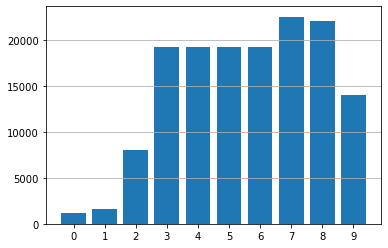

In [24]:
pprint(df.valid_group_days_index.value_counts())
plt.bar(df.valid_group_days_index.value_counts().index, df.valid_group_days_index.value_counts())
plt.xticks(range(10))
plt.grid(axis="y")
plt.show()

**the output column is imbalanced**

In [25]:
# splitting the data
xtrain_day, xtest_day, ytrain_day, ytest_day = train_test_split(x_day, y_day, 
                                                                test_size=0.19, 
                                                                shuffle=True, 
                                                                random_state=seed, 
                                                                stratify=df.valid_group_days_index)

# make oversampling to fix the imbalanced classes
ros = RandomOverSampler(random_state=7)
x_day_train_sampld, y_day_train_sampld = ros.fit_resample(xtrain_day, ytrain_day)

In [26]:
print(f"ytrain_day = {len(ytrain_day)//1000}k,\nytest_day = {len(ytest_day)//1000}k, \ny_day_train_sampld = {len(x_day_train_sampld)//1000}k")

ytrain_day = 118k,
ytest_day = 27k, 
y_day_train_sampld = 182k


6    18257
9    18257
5    18257
2    18257
4    18257
8    18257
7    18257
3    18257
1    18257
0    18257
Name: valid_group_days_index, dtype: int64


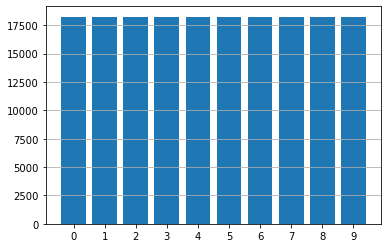

In [27]:
#**after oversampling**
pprint(y_day_train_sampld.value_counts())
plt.bar(y_day_train_sampld.value_counts().index, y_day_train_sampld.value_counts())
plt.xticks(range(10))
plt.grid(axis="y")
plt.show()

In [28]:
class CollectedData(Dataset):
    def __init__(self, x, y):
        self.data = torch.tensor(x.values.astype(np.float32))
        self.label = torch.tensor(y.values)
        self.n_smpl = x.shape[0]
        
        
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
    def __len__(self):
        return self.n_smpl    
    
train_set_day = CollectedData(x_day_train_sampld, y_day_train_sampld)
test_set_day = CollectedData(xtest_day, ytest_day)    

In [29]:
## random_split() isn't suitable here, so that i used train_test_split function
# # train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, int(len(dataset)*0.2)])

# train_labels_day = torch.tensor(ytrain_day.values.astype(np.float32)) 
# test_labels_day = torch.tensor(ytest_day.values.astype(np.float32)) 
# train_input_day = torch.tensor(xtrain_day.values.astype(np.float32)) 
# test_input_day = torch.tensor(xtest_day.values.astype(np.float32)) 

# train_set_day = TensorDataset(train_input_day, train_labels_day)
# test_set_day = TensorDataset(test_input_day, test_labels_day)


In [30]:
batch_size = 128

train_loader_day = DataLoader(dataset=train_set_day, shuffle=True, batch_size=batch_size)
test_loader_day = DataLoader(dataset=test_set_day, batch_size=batch_size) 

In [31]:
class network(nn.Module):
    def __init__(self, in_features=5, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 12)
        self.fc2 = nn.Linear(12, 11)
        self.fc3 = nn.Linear(11, 21)
        self.fc4 = nn.Linear(21, 14)
        self.fc5 = nn.Linear(14, 14)
        self.fc6 = nn.Linear(14, out_features) 
        self.initialize_weights()
        
        
    def forward(self, inpt):
        out = F.relu(self.fc1(inpt))
        out = F.relu(self.fc2(out))
        out = F.leaky_relu(self.fc3(out))
        out = F.leaky_relu(self.fc4(out))
        # out = F.leaky_relu(self.fc5(out))
        out = ((self.fc6(out)))
        # out = F.softmax((self.fc6(out)), dim=1)
        return out
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [32]:
# calculating accuracy
@torch.no_grad()
def calculate_accuracy(model, data_loader=train_loader_day):
    model.eval()
    
    num_correct, num_samples = 0, 0

    for data, labels in data_loader:
        
        # transfering data to cuda
        data = data.to(device=device)
        labels = labels.to(device=device)
                
        preds = model(data)
        num_correct += sum(list(preds.argmax(dim=1)==labels))
        num_samples += len(labels)
    accuracy = num_correct/num_samples
    model.train()
    return accuracy  

In [33]:
# initializing the model
model = network(in_features=5, out_features=10).to(device)
lr = 0.005
# loss and optimizer initializing
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=75, verbose=True)
model

network(
  (fc1): Linear(in_features=5, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=11, bias=True)
  (fc3): Linear(in_features=11, out_features=21, bias=True)
  (fc4): Linear(in_features=21, out_features=14, bias=True)
  (fc5): Linear(in_features=14, out_features=14, bias=True)
  (fc6): Linear(in_features=14, out_features=10, bias=True)
)

In [ ]:
num_epochs = 55
def train_model(num_epochs, data_loader=train_loader_day):
    num_batches = len(data_loader)
    print(f"""batch_size = {batch_size} \n starting learning rate = {lr} \n number of epochs = {num_epochs}\
    \n number of batches = {num_batches} \n model = {model}, \n criterion={criterion}, \n optimizer={optimizer}""")
   
    # starting training loop epochs
    result_train_acc, result_test_acc = [], []
    for epoch in range(num_epochs):
        start_time = time.time()
        progress = tqdm(enumerate(data_loader), total=num_batches, leave=True)
        for batch_idx, (data, labels) in progress: 

            # convert data to device
            data = data.to(device=device)
            labels = labels.to(device=device)

            # getting prediction and loss
            preds = model(data)
            loss = criterion(preds, labels)

            # back propagation
            optimizer.zero_grad()
            loss.backward()

            # optimization step
            optimizer.step()

            progress.set_description(f"epoch [{1+epoch}/{num_epochs}], loss={loss.item():0.4f}")
            progress.set_postfix()

        train_acc = calculate_accuracy(model, data_loader=train_loader_day)
        test_acc = calculate_accuracy(model, data_loader=test_loader_day)
        schedular.step(test_acc)
        print(f"after {1+epoch} epoch, train_accuracy = {(train_acc*100):.2f}%, test_accuracy = {(test_acc*100):.2f}%,\
        time_elapsed = {((time.time()-start_time)/60):.1f} minuts")
        result_train_acc += [train_acc]
        result_test_acc += [test_acc]
    return result_train_acc, result_test_acc
result_train_acc, result_test_acc = train_model(num_epochs, data_loader=train_loader_day)


batch_size = 128 
 starting learning rate = 0.005 
 number of epochs = 55    
 number of batches = 1427 
 model = network(
  (fc1): Linear(in_features=5, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=11, bias=True)
  (fc3): Linear(in_features=11, out_features=21, bias=True)
  (fc4): Linear(in_features=21, out_features=14, bias=True)
  (fc5): Linear(in_features=14, out_features=14, bias=True)
  (fc6): Linear(in_features=14, out_features=10, bias=True)
), 
 criterion=CrossEntropyLoss(), 
 optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)


epoch [1/55], loss=0.5855: 100%|███████████████████████████████████████████████████| 1427/1427 [00:31<00:00, 44.72it/s]


after 1 epoch, train_acc = 83.45%, test_acc = 80.13%,        time_elapsed = 0.6 minuts


epoch [2/55], loss=0.5039: 100%|██████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 109.34it/s]


after 2 epoch, train_acc = 87.83%, test_acc = 84.94%,        time_elapsed = 0.3 minuts


epoch [3/55], loss=0.3410: 100%|███████████████████████████████████████████████████| 1427/1427 [00:14<00:00, 95.98it/s]


after 3 epoch, train_acc = 88.76%, test_acc = 86.32%,        time_elapsed = 0.4 minuts


epoch [4/55], loss=0.4298: 100%|██████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 111.74it/s]


after 4 epoch, train_acc = 86.72%, test_acc = 86.68%,        time_elapsed = 0.3 minuts


epoch [5/55], loss=0.3944: 100%|██████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 113.19it/s]


after 5 epoch, train_acc = 88.89%, test_acc = 86.05%,        time_elapsed = 0.3 minuts


epoch [6/55], loss=0.3709: 100%|██████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 112.64it/s]


after 6 epoch, train_acc = 88.38%, test_acc = 86.52%,        time_elapsed = 0.3 minuts


epoch [7/55], loss=0.3436: 100%|██████████████████████████████████████████████████| 1427/1427 [00:11<00:00, 127.64it/s]


after 7 epoch, train_acc = 89.02%, test_acc = 86.38%,        time_elapsed = 0.3 minuts


epoch [8/55], loss=0.2442: 100%|██████████████████████████████████████████████████| 1427/1427 [00:11<00:00, 123.05it/s]


after 8 epoch, train_acc = 88.55%, test_acc = 86.60%,        time_elapsed = 0.3 minuts


epoch [9/55], loss=0.3147: 100%|██████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 103.75it/s]


after 9 epoch, train_acc = 88.05%, test_acc = 86.83%,        time_elapsed = 0.3 minuts


epoch [10/55], loss=0.1904: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 108.26it/s]


after 10 epoch, train_acc = 85.81%, test_acc = 82.41%,        time_elapsed = 0.3 minuts


epoch [11/55], loss=0.2550: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 108.54it/s]


after 11 epoch, train_acc = 87.60%, test_acc = 85.43%,        time_elapsed = 0.3 minuts


epoch [12/55], loss=0.1938: 100%|█████████████████████████████████████████████████| 1427/1427 [00:11<00:00, 120.80it/s]


after 12 epoch, train_acc = 88.38%, test_acc = 86.61%,        time_elapsed = 0.3 minuts


epoch [13/55], loss=0.2125: 100%|█████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 118.02it/s]


after 13 epoch, train_acc = 88.62%, test_acc = 87.06%,        time_elapsed = 0.3 minuts


epoch [14/55], loss=0.1217: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 106.54it/s]


after 14 epoch, train_acc = 89.19%, test_acc = 86.67%,        time_elapsed = 0.4 minuts


epoch [15/55], loss=0.1860: 100%|█████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 113.40it/s]


after 15 epoch, train_acc = 88.70%, test_acc = 86.90%,        time_elapsed = 0.3 minuts


epoch [16/55], loss=0.4146: 100%|█████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 112.99it/s]


after 16 epoch, train_acc = 88.19%, test_acc = 86.85%,        time_elapsed = 0.4 minuts


epoch [17/55], loss=0.3368: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 106.37it/s]


after 17 epoch, train_acc = 89.01%, test_acc = 87.14%,        time_elapsed = 0.4 minuts


epoch [18/55], loss=0.1532: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 109.63it/s]


after 18 epoch, train_acc = 89.11%, test_acc = 86.60%,        time_elapsed = 0.4 minuts


epoch [19/55], loss=0.2757: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 106.71it/s]


after 19 epoch, train_acc = 88.88%, test_acc = 86.54%,        time_elapsed = 0.4 minuts


epoch [20/55], loss=0.3709: 100%|█████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 110.76it/s]


after 20 epoch, train_acc = 89.11%, test_acc = 86.95%,        time_elapsed = 0.4 minuts


epoch [21/55], loss=0.3101: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 107.29it/s]


after 21 epoch, train_acc = 89.42%, test_acc = 86.78%,        time_elapsed = 0.4 minuts


epoch [22/55], loss=0.4331: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 108.03it/s]


after 22 epoch, train_acc = 89.07%, test_acc = 87.18%,        time_elapsed = 0.4 minuts


epoch [23/55], loss=0.0830: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 108.54it/s]


after 23 epoch, train_acc = 87.94%, test_acc = 85.59%,        time_elapsed = 0.4 minuts


epoch [24/55], loss=0.3253: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 107.56it/s]


after 24 epoch, train_acc = 88.39%, test_acc = 86.76%,        time_elapsed = 0.4 minuts


epoch [25/55], loss=0.2332: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 108.86it/s]


after 25 epoch, train_acc = 89.24%, test_acc = 87.04%,        time_elapsed = 0.4 minuts


epoch [26/55], loss=0.2111: 100%|█████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 110.62it/s]


after 26 epoch, train_acc = 88.69%, test_acc = 86.71%,        time_elapsed = 0.4 minuts


epoch [27/55], loss=0.1176: 100%|█████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 110.23it/s]


after 27 epoch, train_acc = 89.27%, test_acc = 86.91%,        time_elapsed = 0.4 minuts


epoch [28/55], loss=0.2087: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 109.76it/s]


after 28 epoch, train_acc = 89.39%, test_acc = 86.80%,        time_elapsed = 0.4 minuts


epoch [29/55], loss=0.2639: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 103.95it/s]


after 29 epoch, train_acc = 89.25%, test_acc = 86.95%,        time_elapsed = 0.4 minuts


epoch [30/55], loss=0.1351: 100%|█████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 113.13it/s]


after 30 epoch, train_acc = 88.83%, test_acc = 87.24%,        time_elapsed = 0.4 minuts


epoch [31/55], loss=0.1584: 100%|█████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 113.13it/s]


after 31 epoch, train_acc = 89.27%, test_acc = 86.91%,        time_elapsed = 0.3 minuts


epoch [32/55], loss=0.2274: 100%|█████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 110.09it/s]


after 32 epoch, train_acc = 88.13%, test_acc = 87.63%,        time_elapsed = 0.4 minuts


epoch [33/55], loss=0.1794: 100%|█████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 114.03it/s]


after 33 epoch, train_acc = 89.03%, test_acc = 86.77%,        time_elapsed = 0.3 minuts


epoch [34/55], loss=0.3485:  49%|████████████████████████▋                         | 705/1427 [00:06<00:06, 117.58it/s]

In [ ]:
print(f"maximun training accuracy={(max(result_train_acc)*100):.2f}%\nmaximun test accuracy={(max(result_test_acc))*100:.2f}%")

In [ ]:
train_line_val = np.array([val.cpu() for val in result_train_acc]) # just replace val with val.cpu() if output is cuda
test_line_val = np.array([val.cpu() for val in result_test_acc]) # just replace val with val.cpu() if output is cuda

train_line, = plt.plot((range(len(train_line_val))), train_line_val, label="train accuracy", marker="*", linewidth=5)
test_line, = plt.plot((range(len(test_line_val))), test_line_val, label="test accuracy", marker="o", linewidth=2.5)
plt.legend(loc="best", handles=[train_line, test_line])
plt.title("train & test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy percentage")
plt.grid()
plt.show()

In [ ]:
d_test = xtest_day
dt = d_test.copy(deep=True)
d_test = torch.tensor(d_test.values.astype(np.float32))
preds = model(d_test.to(device=device)).argmax(dim=1).cpu()
dt["predicted_days_group_index"] = preds
dt["correct_output"] = ytest_day
dt

In [ ]:
days_tensor = torch.tensor((xtest_daydf[["weekday_name", "month_code", "century_code", "year_code", "leap_year_condition"]].values.astype(np.float32)))
preds = model(days_tensor.to(device=device)).argmax(dim=1).cpu()
preds

In [ ]:
torch.save(model, "../data/day_model_saved")
model = torch.load("../data/day_model_saved")

In [ ]:
dt.to_csv("../data/day_predections.csv", header=True, index=True)